## Requirement 4: Competing Bidding Agents


In [23]:
%pip install grid-strategy

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from grid_strategy import strategies
np.random.seed(42)

### Generalized First Price Auction


In [2]:
class GeneralizedFirstPriceAuction():
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values

    def get_payments_per_click(self, winners, winners_values, bids):
        payments = winners_values/self.ctrs[winners] # Publisher entries
        return payments.round(2)

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

### Bidding Agents

#### Primal-Dual Truthful

In [3]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t, m_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

#### Primal-Dual Non-Truthful

In [4]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

class FFMultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta, K):
        self.bids_set = np.linspace(0, valuation, K)
        self.K = K
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

#### UCB-like algorithm with Negative Feedback when not winning
Best performing UCB-like algorithm from the previous requirements

In [13]:
class UCBNFAgent:
    def __init__(self, valuation, budget, T, range=1,K=None):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.winning_total_reward = 0
        self.won_time = 0
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0

        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, f_t, c_t, m_t):
        self.N_pulls[self.a_t] += 1

        if(f_t>0):
            self.won_time += 1
            self.winning_total_reward += f_t
        elif(self.t >= self.K and self.won_time > 0):
            f_t = - (self.winning_total_reward / self.won_time)

        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

### Simulation

In [14]:
# environment settings
n_users = 10000
valuation = 0.8
B = 5000
eta = 1/np.sqrt(n_users) # from theory
K = 101
rho = B / n_users

n_MPT, n_MPNT, n_UCB = 2,3,4 # agents number
agents = []
agents_lbls = []

for i in range(n_MPT): # Deterministic behaviour so just one agent is enough?
    agents.append(MultiplicativePacingAgent(valuation,B,n_users,eta))
    agents_lbls.append(f"MPT_{i}")

for i in range(n_MPNT):
    agents.append(FFMultiplicativePacingAgent(valuation,B,n_users,0.1,K))
    agents_lbls.append(f"MPNT_{i}")

for i in range(n_UCB): # Deterministic behaviour so just one agent is enough?
    agents.append(UCBNFAgent(valuation,B,n_users,1, K)) # remove K to use K from theory
    agents_lbls.append(f"UCB_{i}")

n_agents = n_MPT + n_MPNT + n_UCB
ctrs = np.ones(n_agents)
n_slots = 3
lambdas = np.array([1, 0.75, .3])
auction = GeneralizedFirstPriceAuction(ctrs, lambdas)


m_t = np.zeros((len(agents), n_users))
utilities = np.zeros((len(agents), n_users))
bids = np.zeros((len(agents), n_users))
payments = np.zeros((len(agents), n_users))
total_wins = np.zeros((len(agents)))

for u in range(n_users):
    for i, agent in enumerate(agents):
        bid = agent.bid()
        bids[i, u] = bid
    round_bids = bids[:, u].ravel()
    winners, _ = auction.round(round_bids)
    winners_set = set(winners)
    winners_mask = np.array([i in winners_set for i in range(n_agents)])
    f_t, c_t = (valuation-round_bids)*winners_mask, round_bids*winners_mask

    for i, agent in enumerate(agents):
      others = np.ones(n_agents, dtype=bool)
      others[i] = False
      m_t[i, u] = np.sort(round_bids[others].flatten())[-n_slots]
      agent.update(f_t[i], c_t[i], m_t[i, u])

    utilities[:,u] = f_t
    payments[:,u] = c_t
    total_wins[winners] += 1

print(f'Total # of Wins: {[f"{l}: {w}" for w, l in zip(total_wins, agents_lbls)]}')

Total # of Wins: ['MPT_0: 7098.0', 'MPT_1: 7099.0', 'MPNT_0: 2279.0', 'MPNT_1: 2214.0', 'MPNT_2: 2253.0', 'UCB_0: 2179.0', 'UCB_1: 2195.0', 'UCB_2: 2287.0', 'UCB_3: 2396.0']


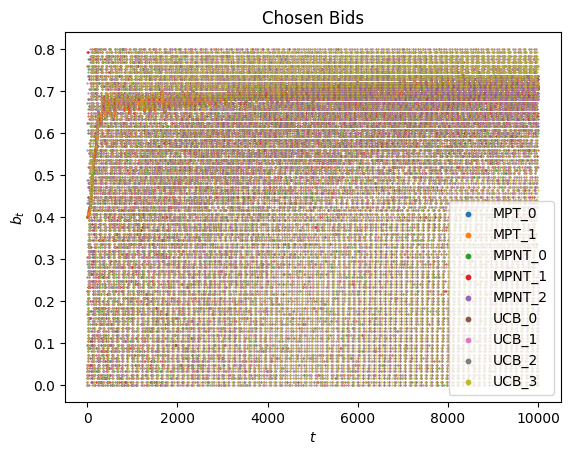

In [15]:
users_x = np.arange(0, n_users, 1, dtype=int)
for i, name in enumerate(agents_lbls):
    plt.scatter(users_x, bids[i], label=name, s=.2)
lgnd = plt.legend()
for handle in lgnd.legend_handles:
    handle.set_sizes([10])
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, n_agents, figsize=(18, 6), sharey=True)

for i, name in enumerate(agents_lbls):
    axs[i].scatter(users_x, bids[i], s=.2)
    axs[i].set_xlabel('$t$')
    axs[i].set_ylabel('$b_t$')
    axs[i].set_title(f'Chosen Bids - {name}')

plt.tight_layout()
plt.show()

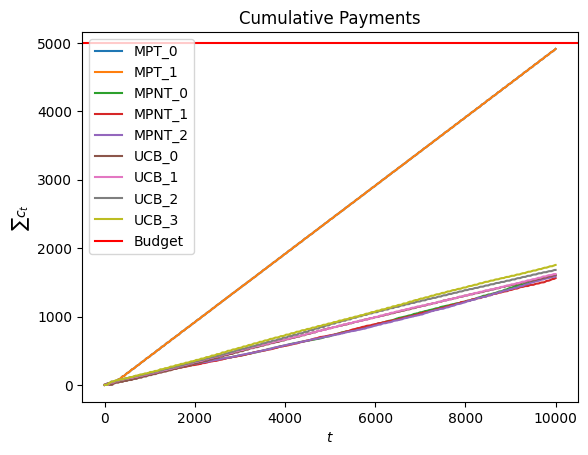

In [17]:
for i, name in enumerate(agents_lbls):
    cumulative_payments = np.cumsum(payments[i])
    plt.plot(cumulative_payments, label=name)
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative Payments')
plt.show()

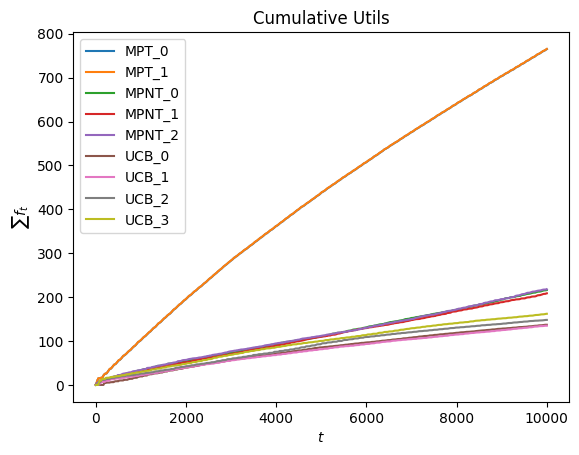

In [18]:
for i, name in enumerate(agents_lbls):
    cumulative_utilities = np.cumsum(utilities[i])
    plt.plot(cumulative_utilities, label=name)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Utils')
plt.show()

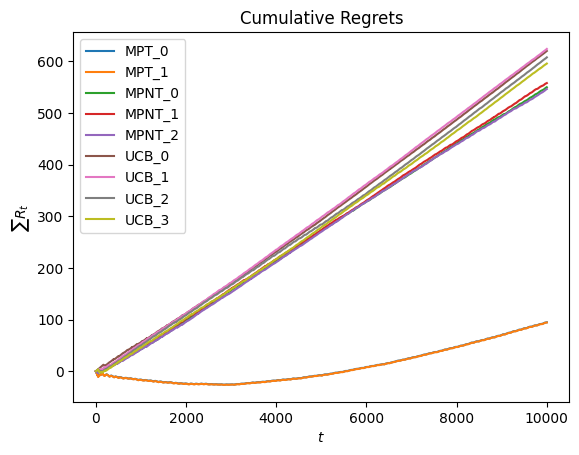

In [19]:
arms = np.linspace(0, valuation, K)

# Compute a different regret for each agent by fixing the other agents' bids
for i, name in enumerate(agents_lbls):
    win_probabilities = np.array([sum(a > m_t[i, :])/n_users for a in arms])
    c = (arms - valuation) * win_probabilities
    A_ub = [arms * win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(K)]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    expected_clairvoyant_utilities = [-res.fun for _ in range(n_users)]
    cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities[i])
    plt.plot(cumulative_regret, label=name)

plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regrets')
plt.show()